## Import Libraies

In [1]:
from time import time
from pathlib import Path
import os
import json
import IPython

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from keras.losses import mean_absolute_percentage_error
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_error

from sklearn.impute import SimpleImputer
import sklearn as sk
from sklearn import svm
from sklearn.decomposition import PCA

# The classes and function were written in a separate file, to streamline the notebook.
from power_consumption_functions import (series_to_supervised
    , json_out, json_to_dict, ModelSeq, shape_for_lstm, shape_for_CNN
    , plot_models_together, plot_prediction, create_summary_table
    , create_summary_table_test, plot_prediction_mulitple)

%load_ext autoreload

%autoreload 2

In [2]:
# Defaults

# Set default plot style
plt.style.use('tableau-colorblind10')

# This is used for saving output in the correct location
cwd = os.getcwd()
notebook_name = 'power_test_v3'

# Introduction
For this project, I investigated modeling household electrical usage. Electricity use among households is a hard topic to model since there is a lot of variance in the electricity use of one household, especially if you compare it to the variance of modeling an entire city. However, that does not mean that there is no value in modeling a household’s use of power. Many places in the world are using power that is priced differently, depending on the time of day. By examining a household's past use and accurately forecasting power, a household can anticipate how much they will spend on power and adjust their usage accordingly. Also, understanding the habits of individual residences also has the potential to help make all power forecasting more accurate. 

I  looked at the contribution of weather forecasting to accurate predictions. Weather can play a large part in the energy usage of a home. Especially in places with fairly large changes in weather, this can have a large effect on the amount of energy that is being used by a household. I have found some models that use temperature in the models, and some that don’t. For this project, I looked at whether adding weather improved the model significantly. 

## Goals
My goal with this project was to build several deep learning models to predict household power usage. I used data that does not contain any weather data. After that model was trained, I then train the same model, but include weather data as a feature. I compared the models and see if it to make a measurable difference in the model's accuracy. The goal of the model is to be predict the next 48 hours, the past seven days of data.

I also looked at the differences in time that it takes to train the model. Any model that is used in a single household situation, the time that it takes to train the model, is important. It might be accurate, but it does not do any good if it needs significant computing power in order to train. 

## Data Information
### Power Consumption Dataset
I am using a dataset called [Individual Household Electric Power Consumption.](https://doi.org/10.24432/C58K54) There are 2,075,259 rows in the dataset. Each row contains seven readings were taken every minute from December 21st, 2006 through November 26th, 2010. The readings were taken from a house in Sceaux, France. I used `Global Active Power` as the dependent variable. This is the number that I want to predict after the model is created.
### Weather Dataset
The second dataset I used contained [weather data](https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) from Paris, France, which is about 15 km from Sceaux. The data was gathered by National Centers for Environmental Information, which is a part of the National Oceanic and Atmospheric Administration (NOAA.) It included nine unique features. The data that I downloaded includes 1822 different rows, each representing a different day. The dataset goes from January 1st, 2006 to December 31st, 2010.

# Data Processing Weather

## Import Weather Data
The only inital thing that I did when importing the weather dataset was make sure that the date value was correctly parsed. 

## Initial Weather Data Analysis

In [3]:
df_wx = pd.read_csv('paris_weather.csv', parse_dates = ['DATE'])
round(df_wx.describe(),3)

,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNWD,TAVG,TMAX,TMIN
count,1822.000,1822.000,1822.0,1822,1800.000,43.000,1822.000,1745.000,1480.000
mean,48.822,2.338,75.0,2008-07-01 12:47:25.225027584,1.666,28.233,12.325,16.719,9.032
min,48.822,2.338,75.0,2006-01-01 00:00:00,0.000,10.000,-4.700,-1.600,-8.900
25%,48.822,2.338,75.0,2007-04-03 06:00:00,0.000,10.000,7.400,10.900,4.600
50%,48.822,2.338,75.0,2008-07-01 12:00:00,0.000,20.000,12.500,17.100,9.450
75%,48.822,2.338,75.0,2009-09-29 18:00:00,1.500,30.000,17.700,22.700,13.900
max,48.822,2.338,75.0,2010-12-31 00:00:00,44.700,109.000,28.700,36.300,22.600
std,0.000,0.000,0.0,NaN,3.948,24.773,6.704,7.781,5.954


In [4]:
df_wx.dtypes

STATION              object
NAME                 object
LATITUDE            float64
LONGITUDE           float64
ELEVATION           float64
DATE         datetime64[ns]
PRCP                float64
SNWD                float64
TAVG                float64
TMAX                float64
TMIN                float64
dtype: object

In [5]:
df_wx.tail()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,SNWD,TAVG,TMAX,TMIN
1817,FRM00007156,"PARIS MONTSOURIS, FR",48.8217,2.3378,75.0,2010-12-27,0.0,10.0,-0.8,0.6,-2.3
1818,FRM00007156,"PARIS MONTSOURIS, FR",48.8217,2.3378,75.0,2010-12-28,NaN,NaN,1.2,NaN,-1.4
1819,FRM00007156,"PARIS MONTSOURIS, FR",48.8217,2.3378,75.0,2010-12-29,0.0,NaN,4.5,7.0,2.5
1820,FRM00007156,"PARIS MONTSOURIS, FR",48.8217,2.3378,75.0,2010-12-30,0.0,NaN,3.2,5.1,NaN
1821,FRM00007156,"PARIS MONTSOURIS, FR",48.8217,2.3378,75.0,2010-12-31,0.0,NaN,1.2,3.2,NaN


## Initial Weather Processing
Before I did any EDA on the weather data, I dropped columns that I knew I wouldn't need, such as the columns that contained the name and location data, since there was only one weather station in the dataset.

I also verified that the column types made sense, based on the data that they contained. 


In [6]:
# Drop unnecessary columns
df_wx = df_wx.drop(['STATION', 'NAME','LATITUDE','LONGITUDE','ELEVATION','SNWD'], axis=1)


In [7]:
round(df_wx.describe(),3)

,DATE,PRCP,TAVG,TMAX,TMIN
count,1822,1800.000,1822.000,1745.000,1480.000
mean,2008-07-01 12:47:25.225027584,1.666,12.325,16.719,9.032
min,2006-01-01 00:00:00,0.000,-4.700,-1.600,-8.900
25%,2007-04-03 06:00:00,0.000,7.400,10.900,4.600
50%,2008-07-01 12:00:00,0.000,12.500,17.100,9.450
75%,2009-09-29 18:00:00,1.500,17.700,22.700,13.900
max,2010-12-31 00:00:00,44.700,28.700,36.300,22.600
std,NaN,3.948,6.704,7.781,5.954


In [8]:
df_wx.dtypes

DATE    datetime64[ns]
PRCP           float64
TAVG           float64
TMAX           float64
TMIN           float64
dtype: object

## Exploratory Data Analysis Weather Dataset

### Null Values
The EDA on the weather dataset was considerably less involved. There were two primary goals of the EDA. The first thing I wanted to do was look for null values in the data. The second thing I wanted to do was verify that there were no readings that looked anomalous, because that could create problems with the data. 

What I found was that there were no obviously anomalous readings in the data. However, there were 424 different rows with null values, which is 23 percent of the dataset. However, after some further analysis of the dataset, I determined that the average temperature did not have any values that were null. For this reason, I used “average temperature” in the final mode

In [9]:
df_wx_nulls = df_wx.isna().any(axis=1)

In [10]:
df_wx[df_wx_nulls]

,DATE,PRCP,TAVG,TMAX,TMIN
0,2006-01-01,0.5,5.6,NaN,3.0
3,2006-01-04,1.5,2.8,5.6,NaN
8,2006-01-09,0.3,4.8,8.1,NaN
15,2006-01-16,0.0,5.1,NaN,2.8
17,2006-01-18,11.4,9.0,NaN,7.1
...,...,...,...,...,...
1812,2010-12-22,0.0,1.8,3.4,NaN
1814,2010-12-24,3.3,0.1,0.8,NaN
1818,2010-12-28,NaN,1.2,NaN,-1.4
1820,2010-12-30,0.0,3.2,5.1,NaN


In [11]:
# Verify that there are no dates that are the same
sum(df_wx['DATE'].duplicated())

0

In [12]:
print(f"Number of null values: {sum(df_wx_nulls)}")
print(f"Percentage of null values: {round(sum(df_wx_nulls)/len(df_wx)*100,2)} percent")

Number of null values: 424
Percentage of null values: 23.27 percent


In [13]:
print('Null Values by Column')
for col in df_wx.columns:
    print(f"{col}: {sum(df_wx[col].isna())}")

Null Values by Column
DATE: 0
PRCP: 22
TAVG: 0
TMAX: 77
TMIN: 342


### Histograms

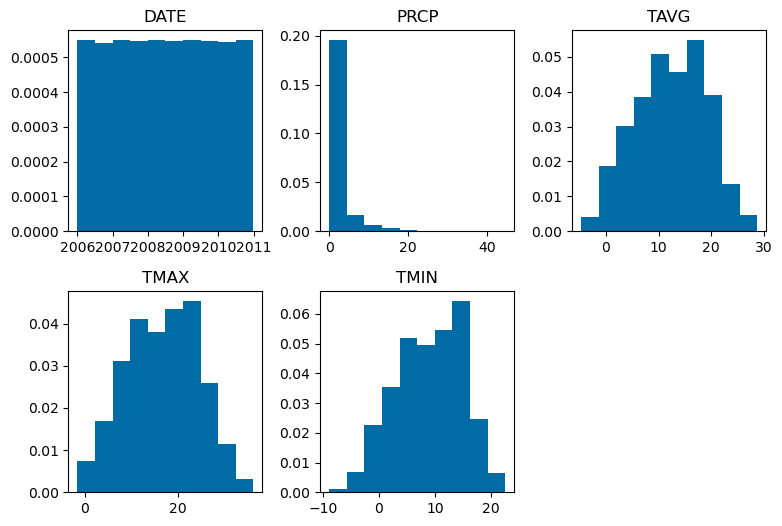

In [14]:
hist = df_wx.hist(figsize=(9, 6), grid = False, layout=(2,3), density = True)

### Missing Dates
Since I was going to be joining this to another dataset, based on the date, I wanted to make sure that there were no dates that were missing. Even though there were zero null values with dates, I did find four dates that were completely missing from the data.

In [15]:
# Create a copy of the dataframe, and change the index to the date.
# Then compare the differences between the index, and a list of all of the dates in the range

df_wx_tmp = df_wx.copy()
df_wx_tmp = df_wx_tmp.set_index('DATE')
 
start_date = min(df_wx['DATE'])
end_date = max(df_wx['DATE'])
missing_dates_df_wx = (pd.date_range(
  start=start_date, end=end_date).difference(df_wx_tmp.index))
print(f"Missing dates: {missing_dates_df_wx}")
print(f"Number of missing dates: {len(missing_dates_df_wx)}")

Missing dates: DatetimeIndex(['2006-08-08', '2006-08-09', '2010-04-25', '2010-04-26'], dtype='datetime64[ns]', freq=None)
Number of missing dates: 4


To correct the missing dates, I took the mean of the month in which the dates were missing, since weather can very so much, depending on the time of year.

In [16]:
df_wx['month'] = df_wx['DATE'].dt.month
columns_list = df_wx.columns[1:]
month_means = df_wx.groupby('month')[columns_list].mean().round(1)


In [17]:
col_values = np.full(len(missing_dates_df_wx), None)
df_wx_tmp2 = pd.DataFrame({'DATE' : missing_dates_df_wx
                           ,'PRCP' : col_values 
                           ,'TAVG': col_values
                           ,'TMAX': col_values
                           ,'TMIN' : col_values
                          })
df_wx_tmp2['month'] = df_wx_tmp2['DATE'].dt.month
# Look at each column individually, and replace the appropriate null values, with the correct mean value. 
for c in columns_list:
    df_wx_tmp2.loc[df_wx_tmp2[c].isnull(),c] = df_wx_tmp2['month'].map(month_means[c])
df_wx_tmp2.dtypes

DATE     datetime64[ns]
PRCP             object
TAVG             object
TMAX             object
TMIN             object
month             int32
dtype: object

In [18]:
# Adds the new dataframe to the old one, and drops the month column
df_wx = pd.concat([df_wx, df_wx_tmp2], ignore_index = True) 
df_wx = df_wx.reset_index() 

In [19]:
df_wx.drop(['index','month'], axis=1, inplace = True)

In [20]:
df_wx = df_wx.infer_objects().round(1)
df_wx.dtypes

DATE    datetime64[ns]
PRCP           float64
TAVG           float64
TMAX           float64
TMIN           float64
dtype: object

In [21]:
df_wx.tail()

,DATE,PRCP,TAVG,TMAX,TMIN
1821,2010-12-31,0.0,1.2,3.2,NaN
1822,2006-08-08,2.9,19.1,24.2,15.1
1823,2006-08-09,2.9,19.1,24.2,15.1
1824,2010-04-25,0.9,12.7,17.8,8.2
1825,2010-04-26,0.9,12.7,17.8,8.2


# Data Processing Power Consumption
## Import Power Consumption Data
When I initially imported the data, I added two columns by splitting the date and time column up into separate columns to make the data processing easier. However, I did not delete the `Date_Time` columns, because that made it easy to maintain the order of the dataset, with one column. I also converted all of the values to floats, except the date and time columns.

In [22]:
df = pd.read_csv('household_power_consumption.txt'
                 , sep=';'
                 , parse_dates=[['Date','Time']]
                 , dayfirst=True
                 , keep_date_col = True
                 , dtype='float64'
                 , na_values = ['?']
                )

df['Date']=pd.to_datetime(df['Date'],dayfirst=True)

In [23]:
df.dtypes

Date_Time                datetime64[ns]
Date                     datetime64[ns]
Time                             object
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object

## Exploratory Data Analysis Power Consumption

In [24]:
df.head()

,Date_Time,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [25]:
# See the earliest and latest dates
print(min(df['Date_Time']))
print(max(df['Date_Time']))

2006-12-16 17:24:00
2010-11-26 21:02:00


In [26]:
df.describe().round(3)

,Date_Time,Date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2075259,2075259,2049280.000,2049280.000,2049280.00,2049280.000,2049280.000,2049280.000,2049280.000
mean,2008-12-06 07:12:59.999994112,2008-12-05 19:13:27.255191040,1.092,0.124,240.84,4.628,1.122,1.299,6.458
min,2006-12-16 17:24:00,2006-12-16 00:00:00,0.076,0.000,223.20,0.200,0.000,0.000,0.000
25%,2007-12-12 00:18:30,2007-12-12 00:00:00,0.308,0.048,238.99,1.400,0.000,0.000,0.000
50%,2008-12-06 07:13:00,2008-12-06 00:00:00,0.602,0.100,241.01,2.600,0.000,0.000,1.000
75%,2009-12-01 14:07:30,2009-12-01 00:00:00,1.528,0.194,242.89,6.400,0.000,1.000,17.000
max,2010-11-26 21:02:00,2010-11-26 00:00:00,11.122,1.390,254.15,48.400,88.000,80.000,31.000
std,NaN,NaN,1.057,0.113,3.24,4.444,6.153,5.822,8.437


In [27]:
total_per_day = len(df[df['Date'] == '2006-12-25'])
print(f"Total Entries per day: {total_per_day}")

Total Entries per day: 1440


### Missing Dates
I checked the power consumption data set for missing dates, and did not find any. 

In [28]:
df_tmp = df.copy()
df_tmp = df_tmp.set_index('Date')
df_tmp.index = (df_tmp.index)
min_date = min(df['Date'])
max_date = max(df['Date'])
missing_dates_df = (pd.date_range(
  start=min_date, end=max_date).difference(df_tmp.index))
print(f"Missing dates: {missing_dates_df}")
print(f"Number of missing dates: {len(missing_dates_df)}")

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq=None)
Number of missing dates: 0


### Add Extra Date and Time Fields
In addition the columns that were in the dataset to start with, I also added four columns related to the dates. The purpose of this was twofold. For starters, some of the data processing and analysis would require this information, such as removing the null values. But secondly, and more importantly, it put the dates and times into formats that can easily be used in our machine learning models. 

I converted the time column to be a decimal, to make it easier to process. In addition, another column that I created translates the date into a day of the year between 1 and 365. This would allow to use the comparison of different dates between years. Since our goal is to make predictions about power usage, having the year as a variable would not be a helpful feature.


In this same vein, I also converted all time into a decimal representation of the times. This makes it easier to use in the model, because time is now a base 10 number.

In [29]:
## Comvert date times to a usable format for ML
df['decimal_time'] = df['Date_Time'].dt.hour + (df['Date_Time'].dt.minute/60)
df['month'] = df['Date_Time'].dt.month
df['day_of_year'] = df['Date_Time'].dt.dayofyear
df['Weekday'] = df['Date_Time'].dt.weekday


### Null Values
#### Discovering
One major task with the initial EDA was to look for null or missing values. I found that there are 25,979 rows that contained at least one missing value. This amounts to 1.25 percent of the dataset. While this was not a lot of null values by percentage, they would still need to be handled.

In [30]:
dfmap = df.isna().any(axis=1)

In [31]:
total_rows = "{:,}".format(len(df))
print(f"Total Rows in dataset: {total_rows}")

Total Rows in dataset: 2,075,259


In [32]:
total_nulls = "{:,}".format(sum(dfmap))
print(f"Total Rows with Nulls in dataset: {total_nulls}")

Total Rows with Nulls in dataset: 25,979


In [33]:
# Percentage of NAs
print(f"Percentage of Rows with NA values: {round((sum(dfmap)/len(df)),4)*100} %")

Percentage of Rows with NA values: 1.25 %


In [34]:
print('Null Values by Column:')
for col in df.columns:
    print(f"{col}: {sum(df[col].isna())}")

Null Values by Column:
Date_Time: 0
Date: 0
Time: 0
Global_active_power: 25979
Global_reactive_power: 25979
Voltage: 25979
Global_intensity: 25979
Sub_metering_1: 25979
Sub_metering_2: 25979
Sub_metering_3: 25979
decimal_time: 0
month: 0
day_of_year: 0
Weekday: 0


#### Replacing Null Values
Since this is time series data, I did not want to just delete all the rows that contained a null value. Since power usage is cyclical, and probably varies based on time, I replaced null values with the mean of the month in which the null value was found. That way, I could keep the rows with the null values, but it is more representative than taking the mean or the median of the entire dataset.

I had already established that there were no null, or missing dates, so these did not have to be corrected in the dataset. 

In [35]:
columns_list = df.columns[3:10]
month_means = df.groupby('month')[columns_list].mean()
month_means

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
month,,,,,,,
1,1.462226,0.110721,242.177646,6.138727,1.406481,1.548839,7.794054
2,1.300431,0.099661,241.459366,5.447099,1.132143,1.386569,7.587332
3,1.231343,0.111257,241.528648,5.176797,1.266721,1.661699,6.928493
4,1.047146,0.122779,241.044744,4.424004,1.075624,1.173244,6.678212
5,1.029571,0.127903,239.008514,4.403161,1.234916,1.307813,6.696841
6,0.909148,0.146254,239.912401,3.926679,1.330837,1.244410,6.172105
7,0.700359,0.151889,240.003656,3.062319,0.707637,0.992232,4.275768
8,0.572812,0.139446,240.173848,2.514592,0.508429,0.804928,3.857316
9,0.975653,0.132875,240.452275,4.169791,1.155922,1.184778,6.356396


In [36]:
# Look at each column individually, and replace the appropriate null values, with the correct mean value. 
for c in columns_list:
    df.loc[df[c].isnull(),c] = df['month'].map(month_means[c])
    

In [37]:
# Verify there are no more null values
df[df.isna().any(axis=1)]

,Date_Time,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,decimal_time,month,day_of_year,Weekday


## Histograms
As a part of my initial EDA, I created histograms of all the features. The main purpose of this was to see if there were any weird outliers in the dataset. After examining the histograms, there weren't any values that seemed unreasonable, or were significant outliers. 

Index(['Date_Time', 'Date', 'Time', 'Global_active_power',
       'Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'decimal_time',
       'month', 'day_of_year', 'Weekday'],
      dtype='object')


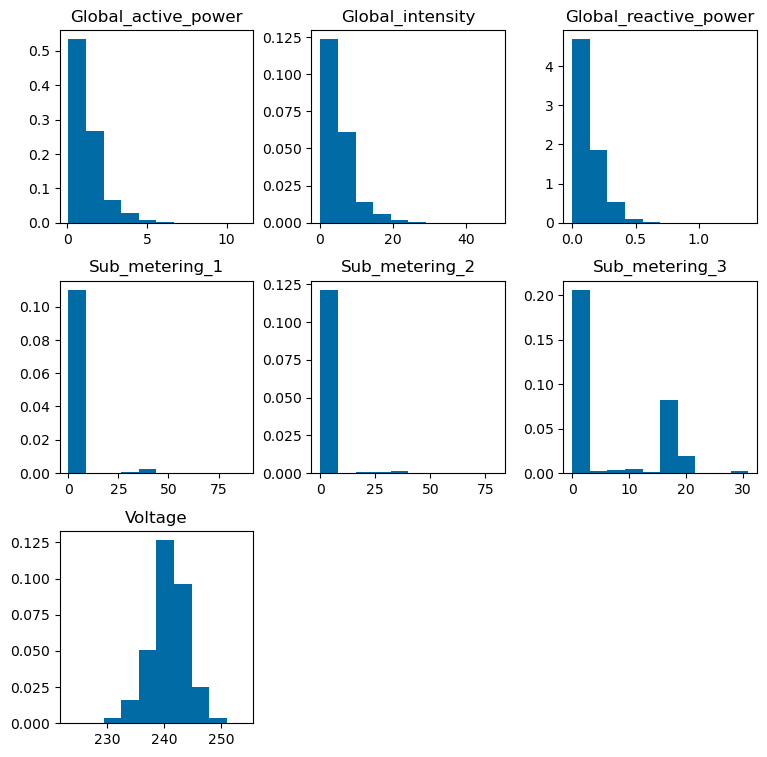

In [38]:
columns = df.columns
print(columns)
hist = df[df.columns.difference(['Date', 'Date_Time', 'Time','decimal_time', 'month', 'day_of_year', 'Weekday'])].hist(
    figsize=(9, 9), grid = False, layout = (3,3), density = True)

In [39]:
df.describe().round(2)

,Date_Time,Date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,decimal_time,month,day_of_year,Weekday
count,2075259,2075259,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.0
mean,2008-12-06 07:12:59.999994112,2008-12-05 19:13:27.255191040,1.09,0.12,240.84,4.62,1.12,1.30,6.45,11.99,6.45,180.96,3.0
min,2006-12-16 17:24:00,2006-12-16 00:00:00,0.08,0.00,223.20,0.20,0.00,0.00,0.00,0.00,1.00,1.00,0.0
25%,2007-12-12 00:18:30,2007-12-12 00:00:00,0.31,0.05,239.02,1.40,0.00,0.00,0.00,6.00,3.00,91.00,1.0
50%,2008-12-06 07:13:00,2008-12-06 00:00:00,0.61,0.10,241.00,2.60,0.00,0.00,1.00,12.00,6.00,181.00,3.0
75%,2009-12-01 14:07:30,2009-12-01 00:00:00,1.52,0.19,242.86,6.40,0.00,1.00,17.00,18.00,9.00,271.00,5.0
max,2010-11-26 21:02:00,2010-11-26 00:00:00,11.12,1.39,254.15,48.40,88.00,80.00,31.00,23.98,12.00,366.00,6.0
std,NaN,NaN,1.05,0.11,3.22,4.42,6.11,5.79,8.39,6.93,3.42,104.52,2.0


## Correlation
Another important feature of EDA is to see if there are any correlated data that would have a tendency to make an inaccurate model. This was interesting because "Global Active Power" and "Global Power Intensity" have a correlation of one. This is something that will need to be addressed in the pre-processing of the data. 

Text(0.5, 1.0, 'Correlation Matrix of Household Power Consumption')

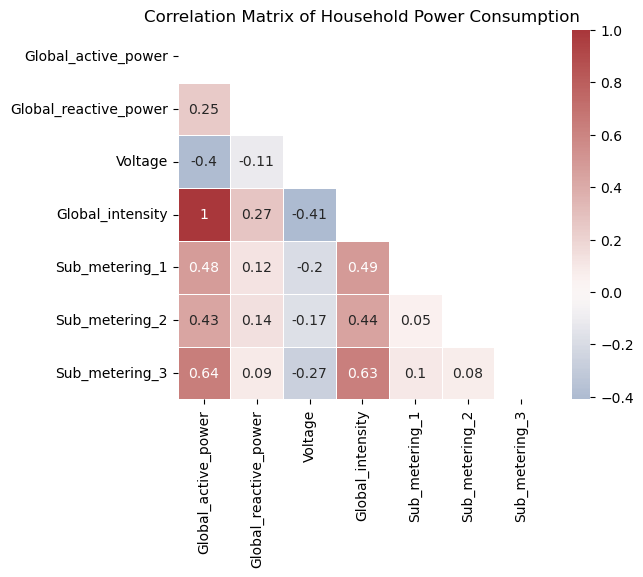

In [40]:
corr = df.iloc[:,3:10].corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.color_palette('vlag', as_cmap=True)
sns.heatmap(corr, mask=mask, cmap = cmap, center=0, annot=True, square=True, linewidths=.5)
plt.title("Correlation Matrix of Household Power Consumption")

## Plot of Global Active Power
I also made a plot of the dependent variable, `Global-active-power`. As expected, it shows that there was a lot of variance in the data. This makes sense when you are looking at a household data. Sometimes there are days with high peaks, and other times, it is very low for several days. We cannot tell from just looking at the data precisely what was going on in these areas, but we all know that most people do not do the exact same things every day. Instead, they do things like go on vacation, which causes their power usage be less than normal. Since people rarely go on vacation, or host large parties, etc., at the same date and time every year, it is hard to predict these large spikes and troughs in the data. 

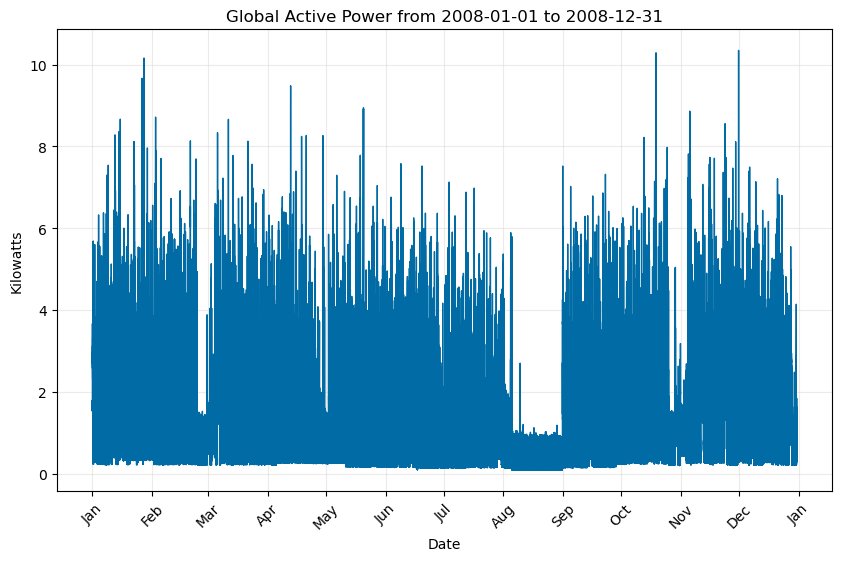

<class 'matplotlib.dates.WeekdayLocator'>


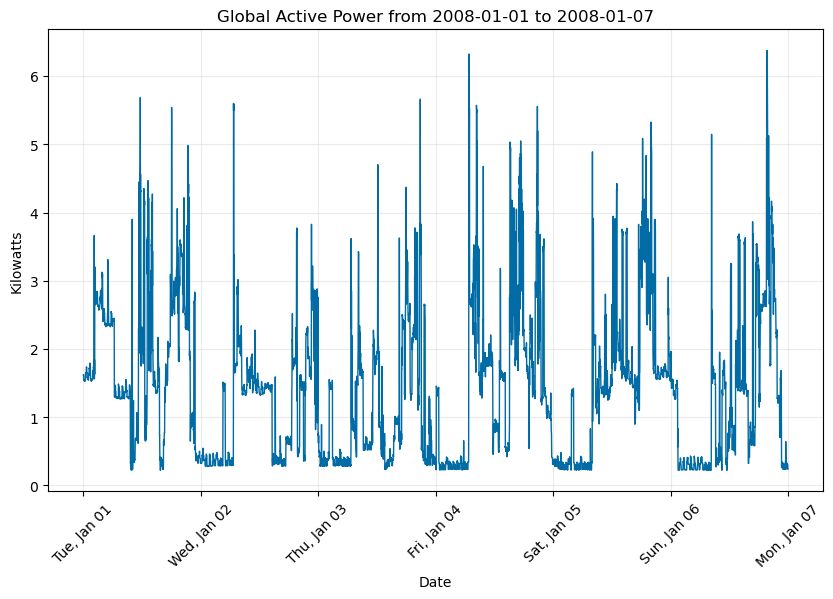

In [41]:
date_ranges = [('2008-01-01', '2008-12-31', 'month'), ('2008-01-01', '2008-01-07', 'week')]

for d in date_ranges:
    plot_start = df[df['Date']== d[0]].index[0]
    plot_end = df[df['Date']== d[1]].index[0]
    
    # Plot the data
    fig, ax = plt.subplots(figsize=(10,6))
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
    ax.plot(df['Date_Time'][plot_start:plot_end], df['Global_active_power'][plot_start:plot_end], linewidth=1)
    ax.set(xlabel="Date", ylabel="Kilowatts",
    title=f"Global Active Power from {d[0]} to {d[1]}")
    
    
    # Define the date format
    if d[2] == 'week':
        # Ticks for every day
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=[]))
        ax.xaxis.set_major_formatter(DateFormatter('%a, %b %d'))
        print(type(mdates.WeekdayLocator(byweekday=[])))
    else:
        # Ticks for every month
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(DateFormatter('%b'))
    plt.xticks(rotation=45)
    plt.show()

# Combined Processing

## Add weather to the main dataframe
It was more challenging than I was initially thinking to adding the weather dataset to the power consumption dataset. I realized you would normally have a forecast for future weather. I included the average temperature for the current day, and also the average temperature for the day that the prediction was being made. To do this, before I converted the power consumption data to be usable for supervised learning, I created a copy that I could then add the weather data to. I used the date column to match up what the average temperature was that day, and also for forty-eight hours in the future. This allowed the data to train on what the “forecast” temperatures would be as well. Once this was done, I then finished pre-processing the data, using the same techniques as the power-consumption only dataset. This included splitting the data “training,” “validation” and “test” datasets, but using the same rows as I used for the power consumption only datasets.

In [42]:
two_days = pd.Timedelta(1, "d")
df['same_day_temp'] = df['Date'].map(df_wx.set_index('DATE')['TAVG'])
df['forecast_date'] = df['Date'] + two_days
df['forecast_temp'] = df['forecast_date'].map(df_wx.set_index('DATE')['TAVG'])
df.drop(['forecast_date'],axis=1, inplace=True)
df.tail()


,Date_Time,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,decimal_time,month,day_of_year,Weekday,same_day_temp,forecast_temp
2075254,2010-11-26 20:58:00,2010-11-26,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0,20.966667,11,330,4,1.3,0.7
2075255,2010-11-26 20:59:00,2010-11-26,20:59:00,0.944,0.0,240.00,4.0,0.0,0.0,0.0,20.983333,11,330,4,1.3,0.7
2075256,2010-11-26 21:00:00,2010-11-26,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0,21.000000,11,330,4,1.3,0.7
2075257,2010-11-26 21:01:00,2010-11-26,21:01:00,0.934,0.0,239.70,3.8,0.0,0.0,0.0,21.016667,11,330,4,1.3,0.7
2075258,2010-11-26 21:02:00,2010-11-26,21:02:00,0.932,0.0,239.55,3.8,0.0,0.0,0.0,21.033333,11,330,4,1.3,0.7


In [43]:
# Verify that there are no null values in the temperature data
print(f"Same_day_temp null values: {sum(df['same_day_temp'].isna())}")
print(f"Forecast_temp null values: {sum(df['forecast_temp'].isna())}")


Same_day_temp null values: 0
Forecast_temp null values: 0


## Reduce Number of Values
To make the dataset more manageable to train, I also compressed the data, so I would have one value for every 15 minutes, instead of readings from every minute. To do this, I took the mean of each feature for every 15 minutes chunk. I  used that instead of data from every minute. This reduced the amount of rows in the dataset to 138,352. Since minute to minute consumption does not vary a lot, I decided that having a more manageable dataset was worth losing a little resolution. 

In [44]:
# Drop unnecessary columns
df_rs = df.drop(['Global_intensity','Date','Time'], axis = 1)

In [45]:
df_rs = (df_rs.resample('15T', on='Date_Time').mean())
df_rs.reset_index(inplace=True)

## Time and Date Changes
### Normalize Date and Time Data
Normalizing the date and time data so that it would work with the modeling process was another part of the data processing. Since power consumption varies considerably with time of day, I had to get the time of day in a format that would be useful for the model. Using time as a value between 0 and 23 would not be helpful, because 0 and 23 are both in the middle of the night and are next to each other. If we left the values at 0 and 23, the model would think that 0 and 23 are values that are nothing like each other, when in actuality, they are very close to each other. I solved this by using the formula:

$$t =\text{Time as a decimal}$$

$$\text{New Time Value}=sin\left (\frac{2 \pi t}{24} \right)$$

Using a sine function maps the time of day to a circle. This eliminates the issue with our time keeping methods that restart the numbers in the middle of the night.

I used a similar technique with dates in the dataset. I created a column that changed the day of the year to an integer between 0 and 364. However, this does not completely solve the problem, because the model would think that January 1st, and December 31st are complete opposites, when in reality, they are similar. I solved that by using the formula:

$$d =\text{Day of the Year}$$
$$\text{New Date Value}=sin\left (\frac{2 \pi d}{365} \right)$$

In [46]:
df_rs['time_standardized'] = np.sin((df_rs['decimal_time']*2*np.pi)/24)
df_rs['day_of_year_standardized'] = np.sin((df_rs['day_of_year']*2*np.pi)/365)

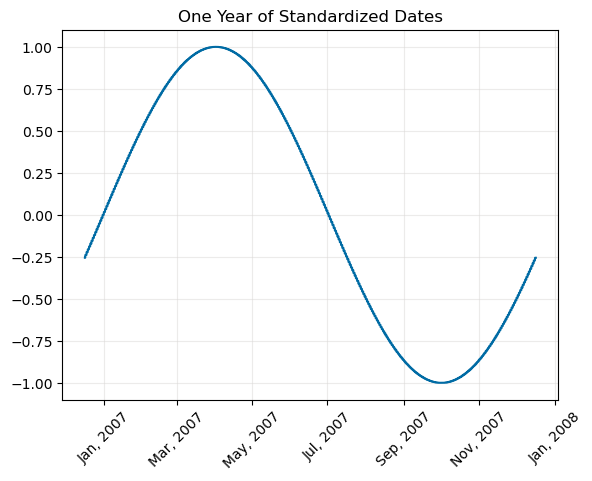

In [47]:
nplot =365*96 #There are 96 time stamps in one day, so this is one year.
fig, ax = plt.subplots()
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
ax.plot(df_rs['Date_Time'].iloc[0:nplot], df_rs['day_of_year_standardized'].iloc[0:nplot])
ax.xaxis.set_major_formatter(DateFormatter('%b, %Y'))
plt.xticks(rotation=45)
plt.title('One Year of Standardized Dates')
plt.show()


In [48]:
df_rs[df_rs['Date_Time']=='2006-12-17 00:00:00']

,Date_Time,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,decimal_time,month,day_of_year,Weekday,same_day_temp,forecast_temp,time_standardized,day_of_year_standardized
27,2006-12-17,2.257333,0.233067,240.448,0.0,1.4,0.0,0.116667,12.0,351.0,6.0,4.4,4.6,0.030539,-0.238673


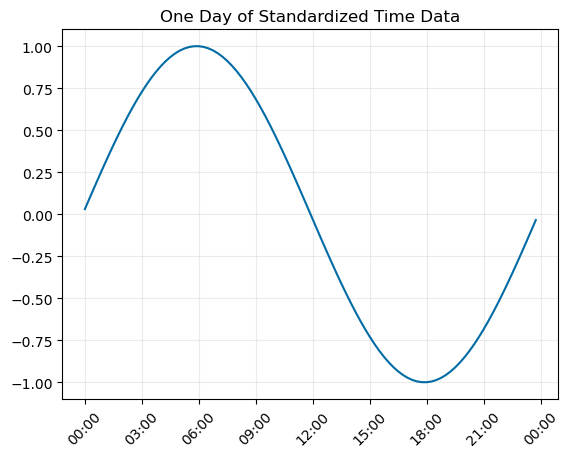

In [49]:
# There are 96 time stamps in one day
nplot = (96*1) + 27 # This is the start of the first full day
fig, ax = plt.subplots()
ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
ax.plot(df_rs['Date_Time'].iloc[27:nplot], df_rs['time_standardized'].iloc[27:nplot])
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.title('One Day of Standardized Time Data')
plt.xticks(rotation=45)

plt.show()

### Weekends
The last thing that I did in relation to dates was using a boolean column to denote if a date was a weekend or not. I did this because power usage can change dramatically based on whether the residents are home. This is not tracked specifically in the data, but if it is a weekend can be one way of helping determine this. I considered using one hot encoding for every day of the week. However, that would add seven new features to the dataset, instead of just one. I decided that there would not be a lot of value in adding that much data, instead of just a true/false “Weekend” column.

In [50]:
# Create a boolean column for if the day of the week is a weekend
df_rs['weekend'] = (np.where(df_rs['Weekday'] >= 5, True, False))


## Final Feature Selection

When all the columns were created, I dropped all the columns that I did not want to use in the final model. This included the `Global_intensity` column that had a 1 to 1 correlation with our dependent variable. In the end, I had ten features that I would use to train the models.

Since I would ultimately need two datasets, I created the one with the addition of temperature first, and then dropped the columns for the model without temperature. 

I then verified that they were the same shape, except with the addition of the two extra columns.

In [51]:
#Drop columns we won't use in the model
df_dropped_wx = df_rs.drop(['month', 'day_of_year','Date_Time', 'Weekday'], axis = 1)
df_dropped = df_dropped_wx.copy()
df_dropped = df_dropped_wx.drop(['same_day_temp', 'forecast_temp'], axis = 1)

print(f"Power Consumption Without Weather dataframe shape: {df_dropped.shape}")
print(f"Power Consumption With Weather dataframe shape: {df_dropped_wx.shape}")

Power Consumption Without Weather dataframe shape: (138352, 10)
Power Consumption With Weather dataframe shape: (138352, 12)


## Convert to Supervised Learning Format
Once I had the dataset finalized, I needed to get it ready to train the model. To do this, I needed to have a format that would allow for supervised training. That means for every value that I wanted to predict, I needed a row of data that included all the features for the 168 hours before the time we want to predict. This increased the amount of features for every prediction tremendously. The result of this is that for every value that needed to be predicted, there were now 6,720 features, instead of ten. With the addition of the two extra temperature columns, this climbed to 8,064 features.



In [52]:
X, y_all = series_to_supervised(df_dropped, ['Global_active_power'], n_in=96*7, n_out=96*2)

In [53]:
X_wx, y_all_wx = series_to_supervised(df_dropped_wx, ['Global_active_power'], n_in=96*7, n_out=96*2)

In [54]:
X_wx.tail()


,Global_active_power(t-672),Global_reactive_power(t-672),Voltage(t-672),Sub_metering_1(t-672),Sub_metering_2(t-672),Sub_metering_3(t-672),decimal_time(t-672),same_day_temp(t-672),forecast_temp(t-672),time_standardized(t-672),...,Voltage(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),decimal_time(t-1),same_day_temp(t-1),forecast_temp(t-1),time_standardized(t-1),day_of_year_standardized(t-1),weekend(t-1)
138156,2.486133,0.122800,237.438667,1.200000,1.200000,17.266667,20.366667,5.1,6.9,-0.814116,...,234.095333,0.0,0.733333,17.000000,20.116667,5.8,3.7,-0.850352,-0.594727,False
138157,1.757333,0.278133,237.592667,1.266667,1.133333,8.266667,20.616667,5.1,6.9,-0.774393,...,232.666000,0.0,0.000000,16.600000,20.366667,5.8,3.7,-0.814116,-0.594727,False
138158,1.107467,0.151733,238.442000,1.133333,0.600000,0.000000,20.866667,5.1,6.9,-0.731354,...,231.341333,0.0,0.000000,16.466667,20.616667,5.8,3.7,-0.774393,-0.594727,False
138159,1.414800,0.030400,239.006000,7.800000,0.000000,0.000000,21.116667,5.1,6.9,-0.685183,...,232.576667,0.0,0.000000,16.600000,20.866667,5.8,3.7,-0.731354,-0.594727,False
138160,2.728933,0.151067,237.688000,28.733333,0.000000,0.000000,21.366667,5.1,6.9,-0.636078,...,231.416667,0.0,0.000000,16.466667,21.116667,5.8,3.7,-0.685183,-0.594727,False


In [55]:
X.tail()

,Global_active_power(t-672),Global_reactive_power(t-672),Voltage(t-672),Sub_metering_1(t-672),Sub_metering_2(t-672),Sub_metering_3(t-672),decimal_time(t-672),time_standardized(t-672),day_of_year_standardized(t-672),weekend(t-672),...,Global_active_power(t-1),Global_reactive_power(t-1),Voltage(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),decimal_time(t-1),time_standardized(t-1),day_of_year_standardized(t-1),weekend(t-1)
138156,2.486133,0.122800,237.438667,1.200000,1.200000,17.266667,20.366667,-0.814116,-0.687053,False,...,2.660000,0.104267,234.095333,0.0,0.733333,17.000000,20.116667,-0.850352,-0.594727,False
138157,1.757333,0.278133,237.592667,1.266667,1.133333,8.266667,20.616667,-0.774393,-0.687053,False,...,2.672667,0.032533,232.666000,0.0,0.000000,16.600000,20.366667,-0.814116,-0.594727,False
138158,1.107467,0.151733,238.442000,1.133333,0.600000,0.000000,20.866667,-0.731354,-0.687053,False,...,1.999867,0.054533,231.341333,0.0,0.000000,16.466667,20.616667,-0.774393,-0.594727,False
138159,1.414800,0.030400,239.006000,7.800000,0.000000,0.000000,21.116667,-0.685183,-0.687053,False,...,1.918933,0.048267,232.576667,0.0,0.000000,16.600000,20.866667,-0.731354,-0.594727,False
138160,2.728933,0.151067,237.688000,28.733333,0.000000,0.000000,21.366667,-0.636078,-0.687053,False,...,2.035867,0.077067,231.416667,0.0,0.000000,16.466667,21.116667,-0.685183,-0.594727,False


In [56]:
# Check the shapes. The first value should be the same with both dataframes
# The second value should be bigger with the addition of the temperature columns
print(f"Shape of X:    {X.shape}")
print(f"Shape of X_WX: {X_wx.shape}")

Shape of X:    (137489, 6720)
Shape of X_WX: (137489, 8064)


## Normalize the data
I also wanted to normalize the data so it would all fall between zero and one. This would allow the model to not overemphasize the differences based on whether a feature has a large range of values or a small one. For this I used the tool, “MinMaxScaler” from Scikit Sklearn. This allowed me to set every feature in the dataset between zero and one. 

In [57]:
# This is done after the to supervised to do it after the y values are separated, so it is not normalized

scaler = MinMaxScaler(feature_range=(0, 1))
start_time = time()
X = scaler.fit_transform(X)
end_time = time()
print(f"Time to run: {end_time-start_time}")




Time to run: 129.33371376991272


In [ ]:
start_time = time()
X_wx = scaler.fit_transform(X_wx)
end_time = time()
print(f"Time to run: {end_time-start_time}")

## Save the Predictive Variable
This project focuses on predicting the power usage forty-eight hours in advance. Therefore, I only used the predicted values from 't+191'. One way to expand this project, would be to predict all of the values between zero and forty-eight hours. 

In [ ]:
y=y_all['Global_active_power(t+191)']
y_wx=y_all_wx['Global_active_power(t+191)']
print(y.shape)
print(y_wx.shape)

## Split Data into Training, Test, and Validation
Since I needed to test my model after I trained it, I split my data into three distinct sets. I created  “training”, “validation” and “test” datasets. The “test” dataset would be used at the very end to compare all the different models. The “training” and “validation” datasets would be used when creating the models and tuning the hyperparameters. Normally, I would use a random sampling of the data to create each of the sets. However, since this is time series data, I needed to keep the data in order. I separated the last 20 percent of the data in to the “test” set. I then split the remaining 80 percent into two other two data sets. I used 2/3 of the remaining data for the “training” set and 1/3 for the “validation” set that would help tune the models.

In [ ]:
# split into train and test sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
val_size = int(train_size * .2)

train_size_wx = int(len(X_wx) * 0.67)
test_size_wx = len(X_wx) - train_size
val_size_wx = int(train_size_wx * .2)



train_X, val_X, test_X = X[0:train_size-val_size,:],X[train_size-val_size:train_size,:], X[train_size:len(X),:]
train_y, val_y, test_y = y[0:train_size-val_size],y[train_size-val_size:train_size], y[train_size:len(y)]

train_X_wx, val_X_wx, test_X_wx = X_wx[0:train_size_wx-val_size_wx,:],X_wx[train_size_wx-val_size_wx:train_size_wx,:], X_wx[train_size_wx:len(X_wx),:]
train_y_wx, val_y_wx, test_y_wx = y_wx[0:train_size_wx-val_size_wx],y_wx[train_size_wx-val_size_wx:train_size_wx], y_wx[train_size_wx:len(y_wx)]


print('Lengths')
print(f"train_X:    {len(train_X)}, val_X:    {len(val_X)}, test_X:    {len(test_X)}")
print(f"train_y:    {len(train_y)}, val_y:    {len(val_y)}, test_y:    {len(test_y)}")
print(f"train_X_wx: {len(train_X_wx)}, val_X_wx: {len(val_X_wx)}, test_X_wx: {len(test_X_wx)}")
print(f"train_y_wx: {len(train_y_wx)}, val_y_wx: {len(val_y_wx)}, test_y_wx: {len(test_y_wx)}")

## Shape for the Neural Network Models
Even though the data was in a supervised format, it was not formatted correctly for our neural network models. 

In [ ]:
train_X_lstm = shape_for_lstm(train_X)
val_X_lstm = shape_for_lstm(val_X)
test_X_lstm = shape_for_lstm(test_X)
train_X_lstm_wx = shape_for_lstm(train_X_wx)
val_X_lstm_wx = shape_for_lstm(val_X_wx)
test_X_lstm_wx = shape_for_lstm(test_X_wx)

train_X_CNN = shape_for_CNN(train_X, n_features = 10)
val_X_CNN = shape_for_CNN(val_X, n_features = 10)
test_X_CNN = shape_for_CNN(test_X, n_features = 10)
train_X_CNN_wx = shape_for_CNN(train_X_wx, n_features = 12)
val_X_CNN_wx = shape_for_CNN(val_X_wx, n_features = 12)
test_X_CNN_wx = shape_for_CNN(test_X_wx, n_features = 12)

# Models
I created three different types of models for this project. To make comparison easier, I initially ran all of the neural network models for 100 epochs.

* A LSTM, which stands for "Long Short Term Memory." It is good for time series data because, it can learn from datapoints in the past. 
* A convolutional neural network model (CNN).
 * Support Vector Machine (SVM)

The goal of the models was to predict the power usage 48 hours after the last time step. Therefore, they all end with one node that is the prediction of the 'Global\_active\_power' for that time-step.

## Model Creation Process
I initially created the models, and then tuned some hyperparameters. To tune the parameters, I trained the model with the training data, and then used the validation data to see how well the model worked with data that was not involved in the training. With the LSTM models, I experimented with several values for the number of units, and did not find a significant difference between them, so I settled on 64 units per LSTM layer. I also varied the number of filters numbers for Conv1D layer in the CNN model and decided on 64.

There are many other ways that I could have tuned the  models. I could have added more layers to the CNN models and experimented with the hyperparameters for pooling. However, the main purpose of this project was to test the addition of weather to the training dataset. I could have continued indefinitely with tuning the models, and had to stop somewhere. 

## Models Without Weather

### LSTM Model 1

In [ ]:
# One 65 neuron layer
lstm_64_1 = ModelSeq([
                LSTM(64, input_shape=(train_X_lstm.shape[1], train_X_lstm.shape[2]))
                , Dense(1)]
          , X_train= train_X_lstm, y_train=train_y, X_val=val_X_lstm, y_val=val_y
          , name = 'LSTM_64_one_layer'
          , initial_lr = .0001
          , notebook_name=notebook_name
          , reload = 100)
lstm_64_1.summary()

In [133]:
# Change reload = 100 to reload =  False, and uncomment out this line to run the model again
lstm_64_1.train_model(epochs=100, batch_size=64, verbose=2)

Epoch 1/100
1152/1152 - 15s - loss: 0.7541 - MSE: 0.7541 - MAE: 0.6221 - MAPE: 108.2777 - val_loss: 0.5323 - val_MSE: 0.5323 - val_MAE: 0.5303 - val_MAPE: 90.3902 - 15s/epoch - 13ms/step
Epoch 2/100
1152/1152 - 10s - loss: 0.6885 - MSE: 0.6885 - MAE: 0.5867 - MAPE: 98.9641 - val_loss: 0.5465 - val_MSE: 0.5465 - val_MAE: 0.5371 - val_MAPE: 94.1190 - 10s/epoch - 8ms/step
Epoch 3/100
1152/1152 - 10s - loss: 0.6538 - MSE: 0.6538 - MAE: 0.5698 - MAPE: 95.0675 - val_loss: 0.5945 - val_MSE: 0.5945 - val_MAE: 0.5800 - val_MAPE: 107.9600 - 10s/epoch - 9ms/step
Epoch 4/100
1152/1152 - 10s - loss: 0.6209 - MSE: 0.6209 - MAE: 0.5540 - MAPE: 91.6875 - val_loss: 0.5652 - val_MSE: 0.5652 - val_MAE: 0.5106 - val_MAPE: 68.1279 - 10s/epoch - 9ms/step
Epoch 5/100
1152/1152 - 10s - loss: 0.5877 - MSE: 0.5877 - MAE: 0.5390 - MAPE: 88.8570 - val_loss: 0.6143 - val_MSE: 0.6143 - val_MAE: 0.5875 - val_MAPE: 109.7701 - 10s/epoch - 9ms/step
Epoch 6/100
1152/1152 - 10s - loss: 0.5535 - MSE: 0.5535 - MAE: 0.5222 

### LSTM Model 2

In [134]:
lstm_64_2 = ModelSeq([
            LSTM(64,
                 input_shape=(train_X_lstm.shape[1], train_X_lstm.shape[2]), return_sequences = True)
                , LSTM(64)
                , Dense(1)]
            , X_train= train_X_lstm, y_train=train_y, X_val=val_X_lstm, y_val=val_y
            , name = 'LSTM_64_two_layers'
            , initial_lr = .0001
            , notebook_name=notebook_name
            , reload = 100)
lstm_64_2.summary()

Model: "LSTM_64_two_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 1, 64)             1736960   
                                                                 
 lstm_23 (LSTM)              (None, 64)                33024     
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,770,049
Trainable params: 1,770,049
Non-trainable params: 0
_________________________________________________________________


In [135]:
lstm_64_2.train_model(epochs=100, batch_size = 64, verbose=2)

Epoch 1/100
1152/1152 - 15s - loss: 0.7980 - MSE: 0.7980 - MAE: 0.6420 - MAPE: 112.1782 - val_loss: 0.5311 - val_MSE: 0.5311 - val_MAE: 0.5351 - val_MAPE: 93.5759 - 15s/epoch - 13ms/step
Epoch 2/100
1152/1152 - 10s - loss: 0.6939 - MSE: 0.6939 - MAE: 0.5861 - MAPE: 98.3480 - val_loss: 0.5260 - val_MSE: 0.5260 - val_MAE: 0.5237 - val_MAPE: 90.2331 - 10s/epoch - 9ms/step
Epoch 3/100
1152/1152 - 10s - loss: 0.6609 - MSE: 0.6609 - MAE: 0.5702 - MAPE: 94.7126 - val_loss: 0.5778 - val_MSE: 0.5778 - val_MAE: 0.5631 - val_MAPE: 102.2952 - 10s/epoch - 9ms/step
Epoch 4/100
1152/1152 - 10s - loss: 0.6309 - MSE: 0.6309 - MAE: 0.5562 - MAPE: 91.3471 - val_loss: 0.5550 - val_MSE: 0.5550 - val_MAE: 0.5038 - val_MAPE: 66.1886 - 10s/epoch - 8ms/step
Epoch 5/100
1152/1152 - 10s - loss: 0.6002 - MSE: 0.6002 - MAE: 0.5428 - MAPE: 88.7369 - val_loss: 0.5782 - val_MSE: 0.5782 - val_MAE: 0.5574 - val_MAPE: 100.7006 - 10s/epoch - 9ms/step
Epoch 6/100
1152/1152 - 10s - loss: 0.5674 - MSE: 0.5674 - MAE: 0.5278 

### CNN Model 1

In [141]:
cnn_64_1 = ModelSeq([
    layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(672,10))
            ,layers.MaxPooling1D(pool_size=2)
            , layers.Flatten()
            , Dense(1)]
    , X_train= train_X_CNN, y_train=train_y, X_val=val_X_CNN, y_val=val_y
    , name = 'CNN_one_layer'
    , initial_lr = .0001
    , notebook_name=notebook_name
    , reload = 100)

In [142]:
cnn_64_1.train_model(epochs=100, batch_size = 64, verbose=2)

Epoch 1/100
1152/1152 - 23s - loss: 0.7957 - MSE: 0.7957 - MAE: 0.6472 - MAPE: 116.8822 - val_loss: 0.5628 - val_MSE: 0.5628 - val_MAE: 0.5542 - val_MAPE: 100.7690 - 23s/epoch - 20ms/step
Epoch 2/100
1152/1152 - 20s - loss: 0.7234 - MSE: 0.7234 - MAE: 0.6075 - MAPE: 105.5529 - val_loss: 0.5507 - val_MSE: 0.5507 - val_MAE: 0.5435 - val_MAPE: 97.1975 - 20s/epoch - 17ms/step
Epoch 3/100
1152/1152 - 13s - loss: 0.7006 - MSE: 0.7006 - MAE: 0.5975 - MAPE: 103.4375 - val_loss: 0.5739 - val_MSE: 0.5739 - val_MAE: 0.5679 - val_MAPE: 105.8038 - 13s/epoch - 11ms/step
Epoch 4/100
1152/1152 - 19s - loss: 0.6858 - MSE: 0.6858 - MAE: 0.5907 - MAPE: 101.7271 - val_loss: 0.5566 - val_MSE: 0.5566 - val_MAE: 0.5270 - val_MAPE: 78.8074 - 19s/epoch - 16ms/step
Epoch 5/100
1152/1152 - 16s - loss: 0.6750 - MSE: 0.6750 - MAE: 0.5865 - MAPE: 100.9651 - val_loss: 0.5786 - val_MSE: 0.5786 - val_MAE: 0.5798 - val_MAPE: 111.1000 - 16s/epoch - 14ms/step
Epoch 6/100
1152/1152 - 12s - loss: 0.6663 - MSE: 0.6663 - MAE

### SVM
I was expecting the SVM model to be the easiest to create, but this was not the case. When I initially created the model with the default parameters, the model had not finished after several hours. This might have just been a limitation of my hardware, but it was not tenable for this project. To solve this, I started off with PCA, which shrank the number of features to 400. However, the model was still taking hours to finish. Because of training time, I trained the model on only 10,000 records. This did work, however, I greater accuracy probably could have been achieved if I had trained on all the records in the dataset. I didn’t spend any time tuning the hyperparameters, since I had to use PCA, and reduce the dataset in order to get the model to work at all. Even if I had fine tuned its accuracy, it still isn’t a good comparison of accuracy against the neural network models, but I can compare it against itself with the weather data added. 

In [144]:
from sklearn.decomposition import PCA
pca_nowx = PCA(n_components=400)
pca_with_wx = PCA(n_components=400)


In [145]:
# I was getting crashing with all the values so I reduced the number of values we were training 
X_train_n = 10000


pca_X_train = pca_nowx.fit_transform(train_X[0:X_train_n])
pca_X_val = pca_nowx.transform(val_X)
pca_X_test = pca_nowx.transform(test_X)

pca_X_train_wx = pca_with_wx.fit_transform(train_X_wx[0:X_train_n])
pca_X_val_wx = pca_with_wx.transform(val_X_wx)
pca_X_test_wx = pca_with_wx.transform(test_X_wx)


In [146]:
sum(pca_nowx.explained_variance_ratio_)

0.9416025816071892

In [147]:
sum(pca_with_wx.explained_variance_ratio_)

0.9420772464591939

In [148]:
pca_X_train.shape

(10000, 400)

In [149]:
# Create the SVM Model
svm_model = svm.SVR(cache_size = 1000)
svm_model.fit(pca_X_train, train_y[0:X_train_n])

SVR(cache_size=1000)

In [152]:
svm_model.get_params()
print(f"Variance accounted for with PCA: {pca_X_train.var().round(3)}")

Variance accounted for with PCA: 0.949


In [153]:
svm_pred = svm_model.predict(pca_X_train)
svm_val_pred = svm_model.predict(pca_X_val)

In [247]:
# Create a dictionary for the SVM model that matches the neural network models
SVM_MSE = mean_squared_error(train_y[0:X_train_n], svm_pred).numpy()
SVM_MSE_val = mean_squared_error(val_y, svm_val_pred).numpy()
SVM_MAPE = mean_absolute_percentage_error(train_y[0:X_train_n], svm_pred).numpy()
SVM_MAE = mean_absolute_error(train_y[0:X_train_n], svm_pred).numpy()
SVM_MAPE_val = mean_absolute_percentage_error(val_y, svm_val_pred).numpy()
SVM_MAE_val = mean_absolute_error(val_y, svm_val_pred).numpy()
svm_stats = {"SVM_no_weather":{
    'MSE': [SVM_MSE],
    'val_MSE': [SVM_MSE_val],
    'MAPE': [SVM_MAPE],
    'val_MAPE': [SVM_MAPE_val],
    'MAE': [SVM_MAE],
    'val_MAE' : [SVM_MAE_val]
}}

## Initial Model Evaluation
After I tuned the hyper parameters, I compared the metrics of the different models, and checked for overfitting. I found the models started to overfit fairly quickly. You can see if a model is beginning to overfit if the metrics of the training data continue to decrease, while the metrics of the validation data go from decreasing to increasing. All models all began to overfit between the second and the seventh epochs. The exact epoch varied from model to model.

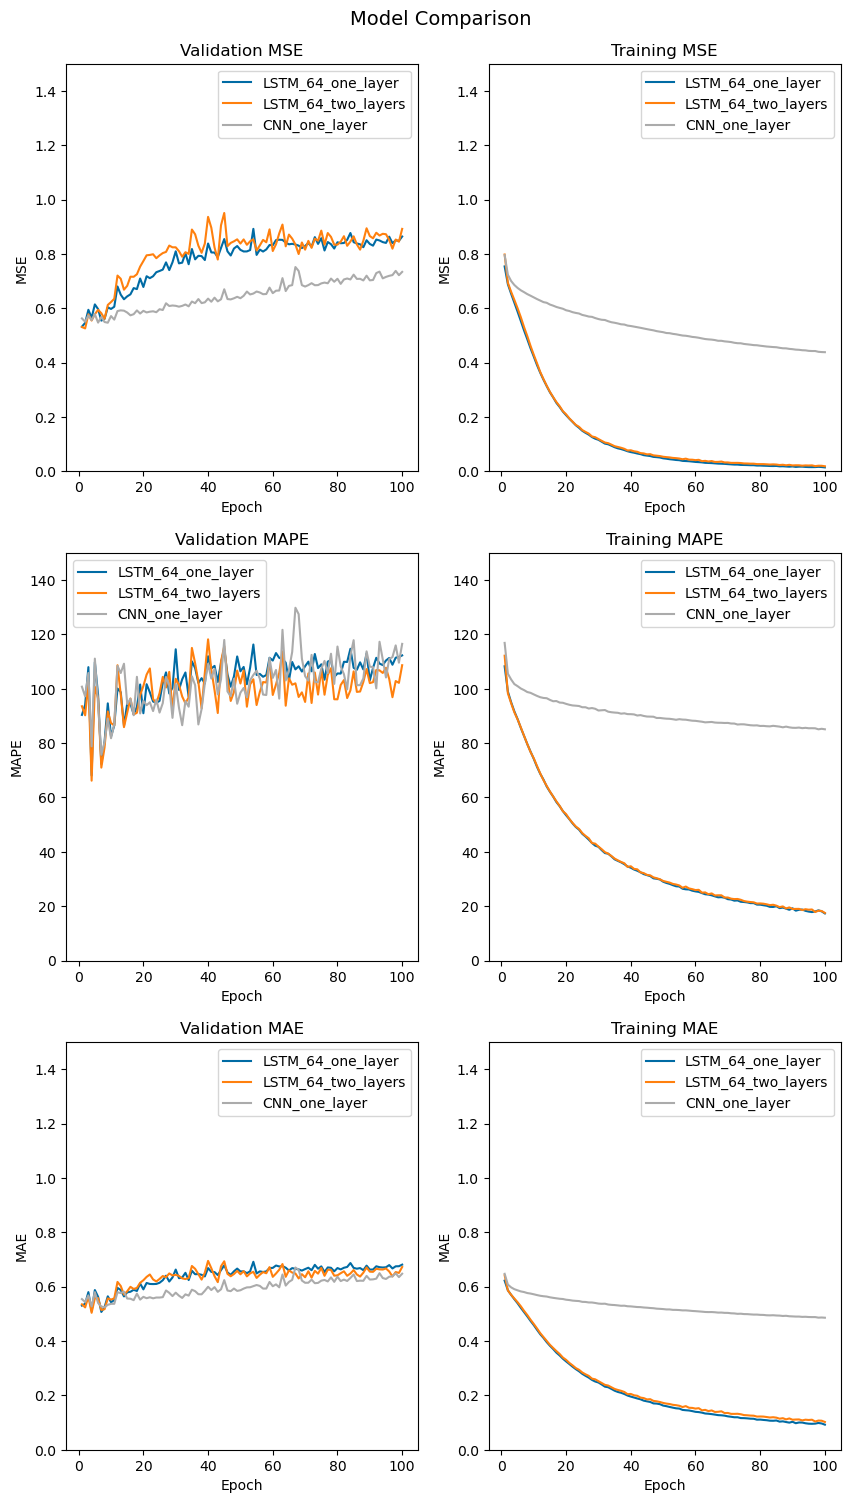

In [255]:
plot_models_together(lstm_64_1.stats|lstm_64_2.stats|cnn_64_1.stats)

In [159]:
st = create_summary_table(lstm_64_1.stats | lstm_64_2.stats | cnn_64_1.stats | svm_stats)

,Model,Minium MSE,Minimum MAPE,Minimum MAE,Minimum Val MSE,Minimum Val MAPE,Minimum Val MAE,Epoch of Min Val MAPE,Epoch of Min Val MSE,Epoch of Min Val MAE
0,LSTM_64_one_layer,0.015,17.333,0.092,0.532,68.128,0.507,4,1,7
1,LSTM_64_two_layers,0.019,17.524,0.102,0.526,66.189,0.504,4,2,4
2,CNN_one_layer,0.439,85.087,0.486,0.547,75.746,0.524,7,9,8
3,SVM_no_weather,0.351,32.755,0.338,0.968,155.064,0.755,1,1,1


## Models with Weather

### LSTM Weather 1

In [173]:
lstm_64_1_wx = ModelSeq([
            LSTM(64, input_shape=(train_X_lstm_wx.shape[1], train_X_lstm_wx.shape[2]))
            , Dense(1)]
                      , X_train= train_X_lstm_wx, y_train=train_y_wx, X_val=val_X_lstm_wx, y_val=val_y_wx
                      , name = 'LSTM_64_one_layer_with_weather'
                      , initial_lr = .0001
                      , notebook_name=notebook_name
                      , reload = 100)
lstm_64_1_wx.summary()

Model: "LSTM_64_one_layer_with_weather"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 64)                2081024   
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,081,089
Trainable params: 2,081,089
Non-trainable params: 0
_________________________________________________________________


In [174]:
lstm_64_1_wx.train_model(epochs = 100, batch_size = 64, verbose=2)

Epoch 1/100
1152/1152 - 13s - loss: 0.7478 - MSE: 0.7478 - MAE: 0.6193 - MAPE: 107.0452 - val_loss: 0.5189 - val_MSE: 0.5189 - val_MAE: 0.5141 - val_MAPE: 82.9394 - 13s/epoch - 11ms/step
Epoch 2/100
1152/1152 - 9s - loss: 0.6856 - MSE: 0.6856 - MAE: 0.5851 - MAPE: 98.8447 - val_loss: 0.5200 - val_MSE: 0.5200 - val_MAE: 0.5097 - val_MAPE: 82.5609 - 9s/epoch - 8ms/step
Epoch 3/100
1152/1152 - 9s - loss: 0.6508 - MSE: 0.6508 - MAE: 0.5685 - MAPE: 94.8072 - val_loss: 0.5800 - val_MSE: 0.5800 - val_MAE: 0.5634 - val_MAPE: 102.5566 - 9s/epoch - 8ms/step
Epoch 4/100
1152/1152 - 9s - loss: 0.6174 - MSE: 0.6174 - MAE: 0.5527 - MAPE: 91.4516 - val_loss: 0.5651 - val_MSE: 0.5651 - val_MAE: 0.5156 - val_MAPE: 70.3366 - 9s/epoch - 8ms/step
Epoch 5/100
1152/1152 - 9s - loss: 0.5835 - MSE: 0.5835 - MAE: 0.5370 - MAPE: 88.5463 - val_loss: 0.5913 - val_MSE: 0.5913 - val_MAE: 0.5701 - val_MAPE: 104.2875 - 9s/epoch - 8ms/step
Epoch 6/100
1152/1152 - 9s - loss: 0.5519 - MSE: 0.5519 - MAE: 0.5217 - MAPE: 8

### LSTM Weather 2

In [175]:
lstm_64_2_wx = ModelSeq([
    LSTM(64,
         input_shape=(train_X_lstm_wx.shape[1], train_X_lstm_wx.shape[2]), return_sequences = True)
                , LSTM(64)
                , Dense(1)]
                        , X_train= train_X_lstm_wx, y_train=train_y_wx, X_val=val_X_lstm_wx, y_val=val_y_wx
                        , name = 'LSTM_64_two_layers_with_weather'
                        , initial_lr = .0001
                        , notebook_name=notebook_name )
lstm_64_2.summary()

Model: "LSTM_64_two_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 1, 64)             1736960   
                                                                 
 lstm_23 (LSTM)              (None, 64)                33024     
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,770,049
Trainable params: 1,770,049
Non-trainable params: 0
_________________________________________________________________


In [176]:
lstm_64_2_wx.train_model(epochs = 100, batch_size = 64, verbose=2)

Epoch 1/100
1152/1152 - 17s - loss: 0.7990 - MSE: 0.7990 - MAE: 0.6467 - MAPE: 114.7142 - val_loss: 0.5187 - val_MSE: 0.5187 - val_MAE: 0.5178 - val_MAPE: 84.7615 - 17s/epoch - 15ms/step
Epoch 2/100
1152/1152 - 12s - loss: 0.7011 - MSE: 0.7011 - MAE: 0.5910 - MAPE: 100.1069 - val_loss: 0.5247 - val_MSE: 0.5247 - val_MAE: 0.5179 - val_MAPE: 86.6613 - 12s/epoch - 10ms/step
Epoch 3/100
1152/1152 - 11s - loss: 0.6717 - MSE: 0.6717 - MAE: 0.5766 - MAPE: 96.7274 - val_loss: 0.5616 - val_MSE: 0.5616 - val_MAE: 0.5512 - val_MAPE: 100.0892 - 11s/epoch - 10ms/step
Epoch 4/100
1152/1152 - 12s - loss: 0.6449 - MSE: 0.6449 - MAE: 0.5632 - MAPE: 93.2893 - val_loss: 0.5549 - val_MSE: 0.5549 - val_MAE: 0.5008 - val_MAPE: 66.4559 - 12s/epoch - 10ms/step
Epoch 5/100
1152/1152 - 11s - loss: 0.6171 - MSE: 0.6171 - MAE: 0.5508 - MAPE: 90.6768 - val_loss: 0.5696 - val_MSE: 0.5696 - val_MAE: 0.5519 - val_MAPE: 99.0611 - 11s/epoch - 10ms/step
Epoch 6/100
1152/1152 - 12s - loss: 0.5873 - MSE: 0.5873 - MAE: 0.5

### CNN Weather 1

In [177]:
train_X_CNN_wx.shape[2]

12

In [178]:
cnn_64_1_wx = ModelSeq([
    layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_X_CNN_wx.shape[1],train_X_CNN_wx.shape[2]))
        ,layers.MaxPooling1D(pool_size=2)
        , layers.Flatten()
        , Dense(1)]
                       , X_train= train_X_CNN_wx, y_train=train_y_wx, X_val=val_X_CNN_wx, y_val=val_y_wx
                       , name = 'CNN_one_layer_with_weather'
                       , initial_lr = .0001
                       , notebook_name=notebook_name)
cnn_64_1_wx.summary()

Model: "CNN_one_layer_with_weather"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 671, 64)           1600      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 335, 64)          0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 21440)             0         
                                                                 
 dense_31 (Dense)            (None, 1)                 21441     
                                                                 
Total params: 23,041
Trainable params: 23,041
Non-trainable params: 0
_________________________________________________________________


In [179]:
cnn_64_1_wx.train_model(epochs = 100, batch_size = 64, verbose=2)

Epoch 1/100
1152/1152 - 35s - loss: 0.7872 - MSE: 0.7872 - MAE: 0.6418 - MAPE: 113.4435 - val_loss: 0.5346 - val_MSE: 0.5346 - val_MAE: 0.5285 - val_MAPE: 88.3187 - 35s/epoch - 30ms/step
Epoch 2/100
1152/1152 - 33s - loss: 0.7148 - MSE: 0.7148 - MAE: 0.6033 - MAPE: 104.1819 - val_loss: 0.5323 - val_MSE: 0.5323 - val_MAE: 0.5296 - val_MAPE: 91.4691 - 33s/epoch - 29ms/step
Epoch 3/100
1152/1152 - 33s - loss: 0.6922 - MSE: 0.6922 - MAE: 0.5929 - MAPE: 101.9731 - val_loss: 0.5640 - val_MSE: 0.5640 - val_MAE: 0.5607 - val_MAPE: 103.1846 - 33s/epoch - 29ms/step
Epoch 4/100
1152/1152 - 32s - loss: 0.6768 - MSE: 0.6768 - MAE: 0.5858 - MAPE: 100.4489 - val_loss: 0.5624 - val_MSE: 0.5624 - val_MAE: 0.5293 - val_MAPE: 76.3353 - 32s/epoch - 28ms/step
Epoch 5/100
1152/1152 - 33s - loss: 0.6641 - MSE: 0.6641 - MAE: 0.5802 - MAPE: 99.4781 - val_loss: 0.5483 - val_MSE: 0.5483 - val_MAE: 0.5487 - val_MAPE: 99.6043 - 33s/epoch - 28ms/step
Epoch 6/100
1152/1152 - 32s - loss: 0.6533 - MSE: 0.6533 - MAE: 0

### SVM  Weather

In [180]:
svm_model_wx = svm.SVR(cache_size = 1000)
svm_model_wx.fit(pca_X_train_wx, train_y_wx[0:X_train_n])

SVR(cache_size=1000)

In [181]:
svm_pred_wx = svm_model_wx.predict(pca_X_train_wx)
svm_val_pred_wx = svm_model_wx.predict(pca_X_val_wx)

In [256]:
SVM_MSE = mean_squared_error(train_y_wx[0:X_train_n], svm_pred_wx).numpy()
SVM_MSE_val = mean_squared_error(val_y_wx, svm_val_pred_wx).numpy()
SVM_MAPE = mean_absolute_percentage_error(train_y_wx[0:X_train_n], svm_pred_wx).numpy()
SVM_MAE = mean_absolute_error(train_y_wx[0:X_train_n], svm_pred_wx).numpy()
SVM_MAPE_val = mean_absolute_percentage_error(val_y_wx, svm_val_pred_wx).numpy()
SVM_MAE_val = mean_absolute_error(val_y_wx, svm_val_pred_wx).numpy()
svm_stats_wx = {"SVM_weather":{
    'MSE': [SVM_MSE],
    'val_MSE': [SVM_MSE_val],
    'MAPE': [SVM_MAPE],
    'val_MAPE': [SVM_MAPE_val],
    'MAE': [SVM_MAE],
    'val_MAE' : [SVM_MAE_val]
}}

# Evaluation

## Metrics Used
For evaluating the models, I used three metrics. One of the metrics used for comparison is MSE, which is mean squared error. This is the metric that I used as the loss functions in the neural network models. MSE is calculated by:

$n$= the number of samples
    
$x$ = actual value

$m$ = predicted value from the model. 


$$\displaystyle MSE = \frac{1}{n}\sum^n_{i=1}(x_i-m_i)^2$$

This is a good metric for time series data, since it tells us how different the predicted data from the model is from the actual data. It does this by subtracting the predicted value from the actual, observed value. If predicted data is exactly the same as the actual data, then the MSE would be zero.

Another metric that I used to compare my models is Mean Absolute Error. It is calculated by:
$$\displaystyle MAE = \frac{1}{n}\sum^n_{i=1} |x_i-m_i|$$

MAE is much like MSE, except that it does not square the values. When the values are squared in MSE, it has the result that it penalizes larger deviations from the mean. However, MAE does not have a greater penalty for larger deviations. Instead, it is a linear penalty. 

There is a third metric that I used for evaluation and that is Mean Absolute Percentage Error. It is calculated by:

$n$= the number of samples

$x$ = actual value

$m$ = predicted value from the model. 

$$\displaystyle MAPE = \frac{1}{n}\sum^n_{i=1} \bigg|\frac{x_i-m_i}{x_i} \bigg |$$

MAPE is a ratio between the difference between the actual value and the predicted value, divided by the actual value. One of its drawbacks is that it penalizes negative errors more than positive errors. Also, it doesn’t work well when the actual value is close to zero, because dividing by zero will create a metric that is close to infinity.

One disadvantage of these methods is there are no specific guidelines for what makes a model good enough. They are also harder to understand than some other metrics, such as accuracy, where it is easy to see how many are right and wrong. But for time series forecasting, it isn’t possible to use accuracy, because you are measuring how close the model is to being right, but for any specific point in time, it will never guess exactly right, like you would for a classification problem. 

## Model Comparison with Test and Validation Data

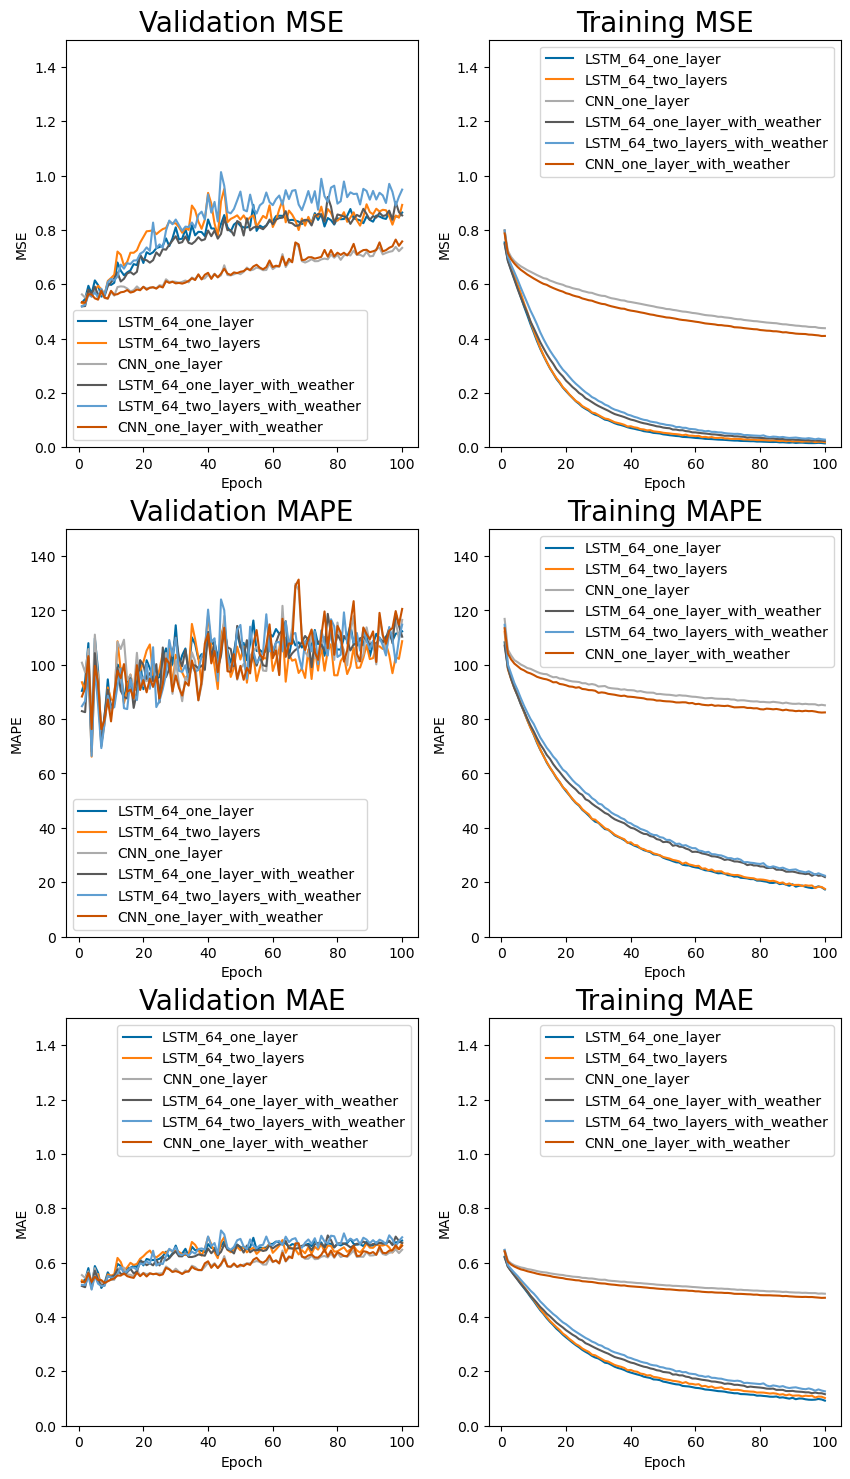

In [184]:
plot_models_together(lstm_64_1.stats|lstm_64_2.stats|cnn_64_1.stats|lstm_64_1_wx.stats|lstm_64_2_wx.stats|cnn_64_1_wx.stats
                     , filename = 'model_comparison1.svg'
                     , no_title = True)


In [185]:
tmp = create_summary_table(lstm_64_1.stats|lstm_64_2.stats|cnn_64_1.stats |lstm_64_1_wx.stats| lstm_64_2_wx.stats|cnn_64_1_wx.stats | svm_stats | svm_stats_wx)                           

,Model,Minium MSE,Minimum MAPE,Minimum MAE,Minimum Val MSE,Minimum Val MAPE,Minimum Val MAE,Epoch of Min Val MAPE,Epoch of Min Val MSE,Epoch of Min Val MAE
0,LSTM_64_one_layer,0.015,17.333,0.092,0.532,68.128,0.507,4,1,7
1,LSTM_64_two_layers,0.019,17.524,0.102,0.526,66.189,0.504,4,2,4
2,CNN_one_layer,0.439,85.087,0.486,0.547,75.746,0.524,7,9,8
3,LSTM_64_one_layer_with_weather,0.023,21.881,0.116,0.519,70.050,0.510,7,1,2
4,LSTM_64_two_layers_with_weather,0.029,22.388,0.127,0.519,66.456,0.501,4,1,4
5,CNN_one_layer_with_weather,0.410,82.419,0.470,0.532,76.292,0.525,7,2,8
6,SVM_no_weather,0.351,32.755,0.338,0.968,155.064,0.755,1,1,1
7,SVM_weather,0.333,30.795,0.326,0.839,128.236,0.690,1,1,1


In [187]:
#print(tmp[['Model','Minimum Val MAPE', 'Minimum Val MSE', 'Minnimum Val MAE','Epoch of Min Val MAPE','Epoch of Min Val MSE']].to_latex(float_format="%.3f",caption = '{Validation Model Minimums Summary Table'))
#print(tmp.to_latex(float_format="%.3f",caption = '{Validation Model Minimums Summary Table'))

## Comparison to test data
Once I finished training and tuning the models, I created final iterations of each model based on what epoch they began to overfit. I loaded checkpoints of the models at these epochs, and used the test data with these models to compare them. 

In [193]:
# One 65 neuron layer
lstm_64_1_final = ModelSeq([
    LSTM(64, input_shape=(train_X_lstm.shape[1], train_X_lstm.shape[2]))
    , Dense(1)]
                      , X_train= train_X_lstm, y_train=train_y, X_val=val_X_lstm, y_val=val_y
                      , name = 'LSTM_64_one_layer'
                      , initial_lr = .0001
                      , reload = 7
                      , notebook_name=notebook_name)


lstm_64_2_final = ModelSeq([
    LSTM(64,
         input_shape=(train_X_lstm.shape[1], train_X_lstm.shape[2]), return_sequences = True)
    , LSTM(64)
    , Dense(1)]
                      , X_train= train_X_lstm, y_train=train_y, X_val=val_X_lstm, y_val=val_y
                      , name = 'LSTM_64_two_layers'
                      , initial_lr = .0001
                      , reload = 4
                      , notebook_name=notebook_name)


cnn_64_1_final = ModelSeq([
    #LSTM(42, input_shape=(train_X_lstm.shape[1], train_X_lstm.shape[2]))
    layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(672,10))
    ,layers.MaxPooling1D(pool_size=2)
    , layers.Flatten()
    , Dense(1)]
                      , X_train= train_X_CNN, y_train=train_y, X_val=val_X_CNN, y_val=val_y
                      , name = 'CNN_one_layer'
                      , initial_lr = .0001
                      , reload = 8
                      , notebook_name=notebook_name)
					  
lstm_64_1_wx_final = ModelSeq([
    LSTM(64, input_shape=(train_X_lstm_wx.shape[1], train_X_lstm_wx.shape[2]))
    , Dense(1)]
                      , X_train= train_X_lstm_wx, y_train=train_y_wx, X_val=val_X_lstm_wx, y_val=val_y_wx
                      , name = 'LSTM_64_one_layer_with_weather'
                      , initial_lr = .0001
                      , reload = 2
                      , notebook_name=notebook_name)

lstm_64_2_wx_final = ModelSeq([
    LSTM(64,
         input_shape=(train_X_lstm_wx.shape[1], train_X_lstm_wx.shape[2]), return_sequences = True)
    , LSTM(64)
    , Dense(1)]
                      , X_train= train_X_lstm_wx, y_train=train_y_wx, X_val=val_X_lstm_wx, y_val=val_y_wx
                      , name = 'LSTM_64_two_layers_with_weather'
                      , initial_lr = .0001
                      , reload = 4
                      , notebook_name=notebook_name)



cnn_64_1_wx_final = ModelSeq([
    #LSTM(42, input_shape=(train_X_lstm.shape[1], train_X_lstm.shape[2]))
    layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(train_X_CNN_wx.shape[1],train_X_CNN_wx.shape[2]))
    ,layers.MaxPooling1D(pool_size=2)
    , layers.Flatten()
    , Dense(1)]
                      , X_train= train_X_CNN_wx, y_train=train_y_wx, X_val=val_X_CNN_wx, y_val=val_y_wx
                      , name = 'CNN_one_layer_with_weather'
                      , initial_lr = .0001
                      , reload = 8
                      , notebook_name=notebook_name)


This model [LSTM_64_one_layer] was reloaded from Epoch 7
Loss: 0.519
Validation Loss: 0.555
This model [LSTM_64_two_layers] was reloaded from Epoch 4
Loss: 0.631
Validation Loss: 0.555
This model [CNN_one_layer] was reloaded from Epoch 8
Loss: 0.652
Validation Loss: 0.55
This model [LSTM_64_one_layer_with_weather] was reloaded from Epoch 2
Loss: 0.686
Validation Loss: 0.52
This model [LSTM_64_two_layers_with_weather] was reloaded from Epoch 4
Loss: 0.645
Validation Loss: 0.555
This model [CNN_one_layer_with_weather] was reloaded from Epoch 8
Loss: 0.636
Validation Loss: 0.551


In [257]:
lstm_model1_rt = sum(lstm_64_1_final.stats['LSTM_64_one_layer']['runtime'])
lstm_model2_rt = sum(lstm_64_2_final.stats['LSTM_64_two_layers']['runtime'])
cnn_rt = sum(cnn_64_1_final.stats['CNN_one_layer']['runtime'])
lstm_model1_wx_rt = sum(lstm_64_1_wx_final.stats['LSTM_64_one_layer_with_weather']['runtime'])
lstm_mode2_wx_rt =  sum(lstm_64_2_wx_final.stats['LSTM_64_two_layers_with_weather']['runtime'])
cnn_wx_rt = sum(cnn_64_1_wx_final.stats['CNN_one_layer_with_weather']['runtime'])        

runtime_list = [
    lstm_model1_rt
    ,lstm_model2_rt
    ,cnn_rt
    ,lstm_model1_wx_rt
    ,lstm_mode2_wx_rt
    ,cnn_wx_rt
    , 'NA'
    , 'NA']

In [196]:
lstm_64_1_final_pred = lstm_64_1_final.predict(test_X_lstm)

1418/1418 [==============================] - 3s 2ms/step


In [197]:
lstm_64_2_final_pred = lstm_64_2_final.predict(test_X_lstm)

1418/1418 [==============================] - 4s 2ms/step


In [198]:
cnn_64_1_final_pred = cnn_64_1_final.predict(test_X_CNN) 

1418/1418 [==============================] - 2s 1ms/step


In [199]:
svm_final_pred = svm_model.predict(pca_X_test)

In [200]:
lstm_64_1_wx_final_pred = lstm_64_1_wx_final.predict(test_X_lstm_wx)

1418/1418 [==============================] - 3s 2ms/step


In [201]:
lstm_64_2_wx_final_pred = lstm_64_2_wx_final.predict(test_X_lstm_wx)

1418/1418 [==============================] - 4s 2ms/step


In [202]:
cnn_64_1_wx_final_pred = cnn_64_1_wx_final.predict(test_X_CNN_wx) 

1418/1418 [==============================] - 2s 1ms/step


In [203]:
svm_final_wx_pred = svm_model_wx.predict(pca_X_test_wx)

In [220]:
prediction_list = [lstm_64_1_final_pred
                   , lstm_64_2_final_pred
                   , cnn_64_1_final_pred
                   , lstm_64_1_wx_final_pred
                   , lstm_64_2_wx_final_pred
                   , cnn_64_1_wx_final_pred
                   , svm_final_pred
                   , svm_final_wx_pred]
model_names = ['lstm_64_1_final_pred'
                   , 'lstm_64_2_final_pred'
                   , 'cnn_64_1_final_pred'
                   , 'lstm_64_1_wx_final_pred'
                   , 'lstm_64_2_wx_final_pred'
                   , 'cnn_64_1_wx_final_pred'
                   , 'SVM_final_pred'
                   , 'SVM_final_wx_pred']
"""X_data_used = [test_X_lstm
                   , test_X_lstm
                   , test_X_CNN
                   , test_X_wx_lstm
                   , test_X_wx_lstm
                   , test_X_wx_CNN]
"""
model_title = ['LSTM Model 1'
                   , 'LSTM Model 2'
                   , 'CNN Model'
                   , 'LSTM Model 1 (wx)'
                   , 'LSTM Model 2 (wx)'
                   , 'CNN Model (wx)'
                   , 'SVM Model'
                   , 'SM Model (wx)']
y_data_used = [test_y
                   , test_y
                   , test_y
                   , test_y_wx
                   , test_y_wx
                   , test_y_wx
                   , test_y
                   , test_y_wx]


In [221]:
stats_final = {}
for i, model in enumerate(model_names):
    #
    MSE = np.mean(mean_squared_error(y_data_used[i], prediction_list[i]).numpy())
    MAPE = np.mean(mean_absolute_percentage_error(y_data_used[i], prediction_list[i]).numpy())
    MAE = np.mean(mean_absolute_error(y_data_used[i], prediction_list[i]).numpy())
    stats_final[model] = {
    'MSE': [MSE],
    'MAPE': [MAPE],
    'MAE': [MAE],
}

In [243]:
final_table = create_summary_table_test(stats_final)
final_table['Runtime'] = pd.to_numeric(runtime_list, errors='coerce')
final_table['Runtime']
final_table.round(2)

,Model,MSE,MAPE,MAE,Runtime
0,lstm_64_1_final_pred,1.20,120.76,0.82,75.23
1,lstm_64_2_final_pred,1.19,117.24,0.82,44.48
2,cnn_64_1_final_pred,1.19,130.72,0.83,138.94
3,lstm_64_1_wx_final_pred,1.24,144.49,0.86,21.49
4,lstm_64_2_wx_final_pred,1.18,113.89,0.81,51.54
5,cnn_64_1_wx_final_pred,1.24,132.82,0.85,263.46
6,SVM_final_pred,1.39,192.80,0.96,NaN
7,SVM_final_wx_pred,1.03,154.20,0.81,NaN


# Model Performance
There were no clear winners when it comes to overall performance of the models. All of the neural network models were similar in overall performance. Not surprisingly, the performance of the SVM model was worse than the neural network models. 

Adding weather data does not obviously make a better model when just looking at the loss metrics. With all three neural network models, the models that incorporated weather did better with MAE and MAPE. However, the MSE numbers were similar, or a little worse. The SVM weather models did better on all three metrics when compared to itself. However, it was the worst performing model overall. This might be explained by the model limitations discussed in the model creation section.  

It is interesting to note that the variability of the MAPE with the validation data is greater than all the other metrics. That makes it hard to use in selecting a final epoch to train the model to.

It is also interesting to look at the data graphically. The models do a pretty good job of matching the cycles of use. However, they are not good at predicting the extremes. This makes sense, and is one potential limitation of household power consumption prediction, because of the variability of individual household power use. Once again, as far as looking at overall performance, the SVM model appeared to perform the worst. 

One interesting thing to note is that the while the models were ultimately similar, the LSTM models with the weather trained faster, both in runtime and the number of epochs it took to train. While it is questionable whether the models with weather were more effective, the LSTM models trained significantly faster. In fact, the LSTM models with weather trained over twice as fast as the LSTM models without weather measured by the time to train. This is certainly a positive thing, since efficiency can be an important part of selecting an algorithm, especially if it is a model that you want to update regularly. 

There are obviously a lot of limitations to this model. To make any real conclusions about the addition of weather data to household power consumption, you would need to use many households with varied habits, as they would all react to the weather differently. 

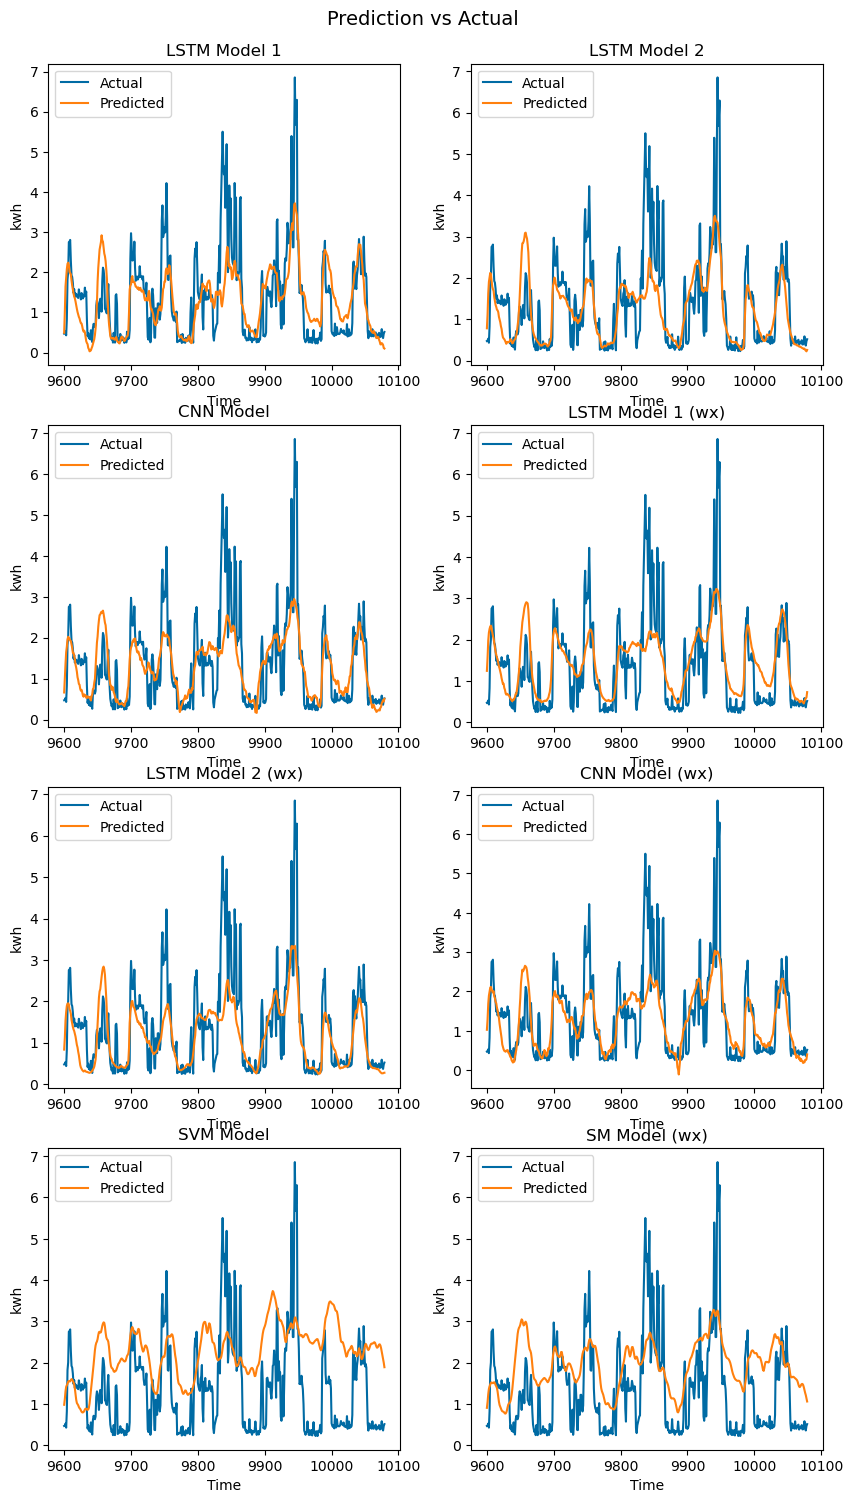

In [361]:
plot_prediction_mulitple(y_data_used
                   , prediction_list
                   , model_title=model_title
                   , legend = True)

# Future Exploration Possibilities

There is always more data exploration that can be done, and that is true with these models. The models could be tuned better, and this might make them more accurate. Another thing that make be an improvement would be to incorporate feature reduction techniques like PCA on the data for the neural network models as well. This might improve the runtime of the models, without adversely affecting the final effectiveness of the model. 

There are other ways that these models tuned in the future. For instance, changing the amount of hours looking backward could help optimize the model. Perhaps looking fewer hours into the past would give the same results as seven full days. In this same vein, one could look further forward and see how many days in the future one can predict with similar accuracy. 

Another way that these models might be improved would be to use hourly temperature readings, instead of just daily. That would help with power usage when the weather changes dramatically, and it differs significantly from the average for the day. Also, this model had a little of an advantage because the “forecast” data was not what was forecast at the time the power was recorded, but the actual temperatures for that day. While temperature forecasting is improving, we all know it isn’t an exact science, and if we are truly predicting weather in the future, we would only 
have access to forecast data. 

# Conclusion
For this project, I made a comparison of three neural network models, and a Support Vector Machine. The neural network models all were all fairly similar in their final accuracy, while the SVM did not perform as well. These models were also trained same dataset, but with the addition of daily average temperature data to the dataset. This was done to compare the models and to see if there was a measurable difference with the addition of temperature to the dataset.  

In the end, it was inconclusive if the addition of the weather data helped the model or not. However, the LSTM neural network models trained 2x faster, which is certainly a positive thing in modeling. 

# References
Alberto Gasparin, Slobodan Lukovic, and Cesare Alippi. 2019. Deep Learning for
Time Series Forecasting: The Electric Load Case. CAAI Trans. Intell. Technol. 7
(2019), 1–25. https://api.semanticscholar.org/CorpusID:198147971

F. Pedregosa, G. Varoquaux, A. Gramfort, V. Michel, B. Thirion, O. Grisel, M.
Blondel, P. Prettenhofer, R. Weiss, V. Dubourg, J. Vanderplas, A. Passos, D. Cour-
napeau, M. Brucher, M. Perrot, and E. Duchesnay. 2011. Scikit-learn: Machine
Learning in Python. Journal of Machine Learning Research 12 (2011), 2825–2830.

François Chollet et al. 2015. Keras. https://keras.io.

Georges Hebrail and Alice Berard. 2012. Individual household electric power
consumption. UCI Machine Learning Repository. https://doi.org/10.24432/C58K54

Hong-Tzer Yang, Chao-Ming Huang, and Ching-Lien Huang. 1996. Identification
of ARMAX model for short term load forecasting: an evolutionary programming
approach. IEEE Transactions on Power Systems 11, 1 (1996), 403–408. https://doi.org/10.1109/59.486125

Jason Brownless. 2019. How to Convert a Time Series to a Supervised Learning
Problem in Python. https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo, Zhifeng Chen,
Craig Citro, Greg S. Corrado, Andy Davis, Jeffrey Dean, Matthieu Devin, San-
jay Ghemawat, Ian Goodfellow, Andrew Harp, Geoffrey Irving, Michael Isard,
Yangqing Jia, Rafal Jozefowicz, Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg,
Dandelion Mané, Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Mike
Schuster, Jonathon Shlens, Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul
Tucker, Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas, Oriol Vinyals,
Pete Warden, Martin Wattenberg, Martin Wicke, Yuan Yu, and Xiaoqiang Zheng.
2015. TensorFlow: Large-Scale Machine Learning on Heterogeneous Systems.
https://www.tensorflow.org/

National Centers for Environmental Information (NCEI). 2023. Climate Data
Online Search. https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND

Nicholas I. Sapankevych and Ravi Sankar. 2009. Time Series Prediction Using
Support Vector Machines: A Survey. IEEE Computational Intelligence Magazine 4,
2 (2009), 24–38. [https://doi.org/10.1109/MCI.2009.932254](https://doi.org/10.1109/MCI.2009.932254)

Scikit Learn. 2023. sklearn.svm.SVC. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

Scikit Learn. 2023. Support Vector Machines. https://scikit-learn.org/stable/modules/svm.html




